# Big Data Analytics Project 
# Min Khant Kyaw 6410935

# Data Ingestion

In [2]:
## mongoexport --uri "" --collection sales --out sales.json

import pandas as pd

# Load the JSON file into a Pandas DataFrame
salesdf = pd.read_json('sales.json', lines=True)


# Intro: Install necessary libaries

In [3]:
!pip install pandas

In [4]:
num_rows, num_columns = salesdf.shape

print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}")

Number of Rows: 5000
Number of Columns: 7


# 1. Show top 10 products (name) sales (quantity x price)

In [5]:
from IPython.display import display, HTML

html_table = salesdf.head(3).to_html(classes='customtable', index=False)

# Define custom CSS styles to color the header
styles = """
    <style>
        .customtable {
            border-collapse: collapse;
            width: 100%;
        }
        .customtable th {
            background-color: #4e20ce; /* background color for header */
            color: white; /* White text color for header */
            border: 1px solid black;
            padding: 8px;
            text-align: left;
        }
        .customtable td {
            border: 1px solid black;
            padding: 8px;
            text-align: left;
        }
    </style>
"""

# Display the HTML with custom styles
display(HTML(styles + html_table))


_id,saleDate,items,storeLocation,customer,couponUsed,purchaseMethod
{'$oid': '5bd761dcae323e45a93ccfe8'},{'$date': '2015-03-23T21:06:49.506Z'},"[{'name': 'printer paper', 'tags': ['office', 'stationary'], 'price': {'$numberDecimal': '40.01'}, 'quantity': 2}, {'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '35.29'}, 'quantity': 2}, {'name': 'pens', 'tags': ['writing', 'office', 'school', 'stationary'], 'price': {'$numberDecimal': '56.12'}, 'quantity': 5}, {'name': 'backpack', 'tags': ['school', 'travel', 'kids'], 'price': {'$numberDecimal': '77.71'}, 'quantity': 2}, {'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '18.47'}, 'quantity': 2}, {'name': 'envelopes', 'tags': ['stationary', 'office', 'general'], 'price': {'$numberDecimal': '19.95'}, 'quantity': 8}, {'name': 'envelopes', 'tags': ['stationary', 'office', 'general'], 'price': {'$numberDecimal': '8.08'}, 'quantity': 3}, {'name': 'binder', 'tags': ['school', 'general', 'organization'], 'price': {'$numberDecimal': '14.16'}, 'quantity': 3}]",Denver,"{'gender': 'M', 'age': 42, 'email': 'cauho@witwuta.sv', 'satisfaction': 4}",True,Online
{'$oid': '5bd761dcae323e45a93ccfe9'},{'$date': '2015-08-25T10:01:02.918Z'},"[{'name': 'envelopes', 'tags': ['stationary', 'office', 'general'], 'price': {'$numberDecimal': '8.05'}, 'quantity': 10}, {'name': 'binder', 'tags': ['school', 'general', 'organization'], 'price': {'$numberDecimal': '28.31'}, 'quantity': 9}, {'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '20.95'}, 'quantity': 3}, {'name': 'laptop', 'tags': ['electronics', 'school', 'office'], 'price': {'$numberDecimal': '866.5'}, 'quantity': 4}, {'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '33.09'}, 'quantity': 4}, {'name': 'printer paper', 'tags': ['office', 'stationary'], 'price': {'$numberDecimal': '37.55'}, 'quantity': 1}, {'name': 'backpack', 'tags': ['school', 'travel', 'kids'], 'price': {'$numberDecimal': '83.28'}, 'quantity': 2}, {'name': 'pens', 'tags': ['writing', 'office', 'school', 'stationary'], 'price': {'$numberDecimal': '42.9'}, 'quantity': 4}, {'name': 'envelopes', 'tags': ['stationary', 'office', 'general'], 'price': {'$numberDecimal': '16.68'}, 'quantity': 2}]",Seattle,"{'gender': 'M', 'age': 50, 'email': 'keecade@hem.uy', 'satisfaction': 5}",False,Phone
{'$oid': '5bd761dcae323e45a93ccfea'},{'$date': '2017-06-22T09:54:14.185Z'},"[{'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '30.08'}, 'quantity': 1}, {'name': 'binder', 'tags': ['school', 'general', 'organization'], 'price': {'$numberDecimal': '24.68'}, 'quantity': 7}, {'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '32.1'}, 'quantity': 4}, {'name': 'pens', 'tags': ['writing', 'office', 'school', 'stationary'], 'price': {'$numberDecimal': '31.41'}, 'quantity': 3}, {'name': 'printer paper', 'tags': ['office', 'stationary'], 'price': {'$numberDecimal': '43.56'}, 'quantity': 3}, {'name': 'pens', 'tags': ['writing', 'office', 'school', 'stationary'], 'price': {'$numberDecimal': '68.95'}, 'quantity': 4}, {'name': 'notepad', 'tags': ['office', 'writing', 'school'], 'price': {'$numberDecimal': '8.57'}, 'quantity': 4}, {'name': 'backpack', 'tags': ['school', 'travel', 'kids'], 'price': {'$numberDecimal': '106.6'}, 'quantity': 2}, {'name': 'laptop', 'tags': ['electronics', 'school', 'office'], 'price': {'$numberDecimal': '596.33'}, 'quantity': 4}]",Denver,"{'gender': 'M', 'age': 51, 'email': 'worbiduh@vowbu.cg', 'satisfaction': 5}",False,In store


In [6]:

# Extract relevant information from the 'items' column
items_df = pd.json_normalize(salesdf['items'].explode()).reset_index()

In [7]:

head_rows = items_df.head(3)
tail_rows = items_df.tail(3)

# Add a row with "..." to indicate skipped rows
ellipsis_row = pd.DataFrame(["..."] * len(head_rows.columns)).T
ellipsis_row.columns = head_rows.columns
table_with_ellipsis = pd.concat([head_rows, ellipsis_row, tail_rows])

# Convert to HTML
html_table = table_with_ellipsis.head(5).to_html(classes='customtable', index=False)

# Display the HTML with custom styles for items_df
display(HTML(styles + html_table))

index,name,tags,quantity,price.$numberDecimal
0,printer paper,"[office, stationary]",2,40.01
1,notepad,"[office, writing, school]",2,35.29
2,pens,"[writing, office, school, stationary]",5,56.12
...,...,...,...,...
27435,binder,"[school, general, organization]",3,29.09


In [8]:

items_df['sales'] = items_df['quantity'] * items_df['price.$numberDecimal'].astype(float)

# Group by product name and calculate total sales
product_sales = items_df.groupby('name')['sales'].sum().reset_index()

# Select the top 10 products based on total sales
Top_10_Product_Sales = product_sales.sort_values(by='sales', ascending=False).head(10)

# Add a new column 'rank' with numbers (1, 2, 3, ...)
Top_10_Product_Sales.insert(0, 'Top10', range(1, len(Top_10_Product_Sales) + 1))

# Convert to HTML
html_table = Top_10_Product_Sales.to_html(classes='customtable', index=False)

# Add a title to the table
table_title = '<h2>Top 10 Product Sales (Quantity x Price)    <--------</h2>'

# Display the HTML with custom styles for Top_10_Product_Sales
display(HTML(styles + table_title + html_table))


Top10,name,sales
1,laptop,6775977.07
2,backpack,817374.10
3,pens,581843.27
4,binder,511644.57
5,notepad,463615.48
6,envelopes,376658.49
7,printer paper,367459.29


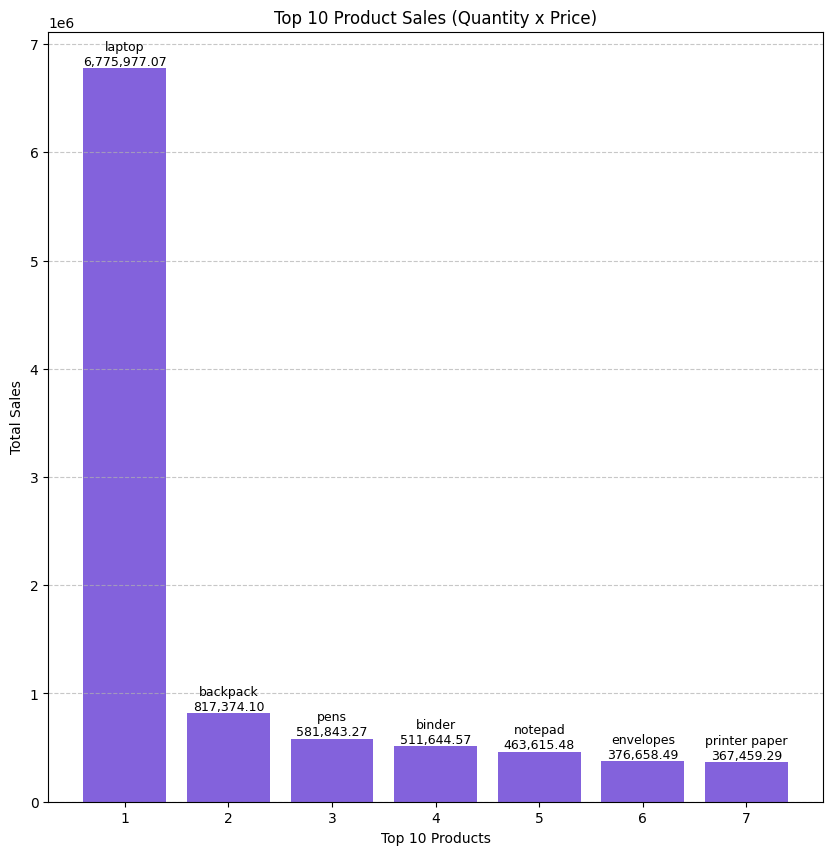

In [27]:
import matplotlib.pyplot as plt

# Plotting the bar chart
plt.figure(figsize=(10, 10))
bars = plt.bar(Top_10_Product_Sales['Top10'], Top_10_Product_Sales['sales'], color='#4e20ce', alpha=0.7)
plt.xlabel('Top 10 Products')
plt.ylabel('Total Sales')
plt.title('Top 10 Product Sales (Quantity x Price)')

# Displaying the names and sales numbers on top of the bars
for bar, name, sales in zip(bars, Top_10_Product_Sales['name'], Top_10_Product_Sales['sales']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{name}\n{sales:,.2f}', 
             ha='center', va='bottom', color='black', fontsize=9)

plt.xticks(Top_10_Product_Sales['Top10'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()



#### Total 7 items exist in the dataset,  backpack has second highest sale 581,843.27pens , binder, notepad, envelopes and finally printer paper follows
laptop has the highest sales due to its nature having high prices and it is a tech product whereas we have backpack, pen , binder, notepad envelopes and printer paper which are stationaries with low to mid value prices. Excluding laptop, they are fall under same category. while combining all of them together and compare with laptop alone, still laptop stand out all the other 6 items. This shows tech products play a role in immerse sale in the market. Laptop is a high demand among customers than all the other 6 items conbined



     

# 2.Show Top 3 Products (name) Sales by  Store(location)

In [10]:
salesbystore = salesdf[['storeLocation','purchaseMethod','saleDate']].reset_index()

In [11]:
merged_df = pd.merge(items_df,salesbystore, left_on='index', right_on='index')
html_table = merged_df.head().to_html(classes='customtable', index=False)
display(HTML(styles + html_table))


index,name,tags,quantity,price.$numberDecimal,sales,storeLocation,purchaseMethod,saleDate
0,printer paper,"[office, stationary]",2,40.01,80.02,Denver,Online,{'$date': '2015-03-23T21:06:49.506Z'}
1,notepad,"[office, writing, school]",2,35.29,70.58,Seattle,Phone,{'$date': '2015-08-25T10:01:02.918Z'}
2,pens,"[writing, office, school, stationary]",5,56.12,280.60,Denver,In store,{'$date': '2017-06-22T09:54:14.185Z'}
3,backpack,"[school, travel, kids]",2,77.71,155.42,Seattle,In store,{'$date': '2015-02-23T09:53:59.343Z'}
4,notepad,"[office, writing, school]",2,18.47,36.94,London,In store,{'$date': '2017-12-03T18:39:48.253Z'}


In [12]:

top_3_productsales_by_store = (
    merged_df.groupby(['storeLocation', 'name'])['sales']
    .sum()
    .reset_index()
    .sort_values(by=['storeLocation', 'sales'], ascending=[True, False])
    .groupby('storeLocation')
    .head(3)
)


top_3_productsales_by_store.insert(0, 'Top3', range(1, len(top_3_productsales_by_store) + 1))


html_table = top_3_productsales_by_store.to_html(classes='customtable', index=False)


table_title = '<h2>Top 3 Product Sales by Store   <--------</h2>'

display(HTML(styles + table_title + html_table))


Top3,storeLocation,name,sales
1,Austin,laptop,158970.49
2,Austin,backpack,23265.19
3,Austin,binder,13618.05
4,Denver,laptop,409752.19
5,Denver,backpack,44224.19
6,Denver,pens,32667.76
7,London,laptop,201480.89
8,London,backpack,22946.59
9,London,pens,17510.10
10,New York,laptop,177308.46


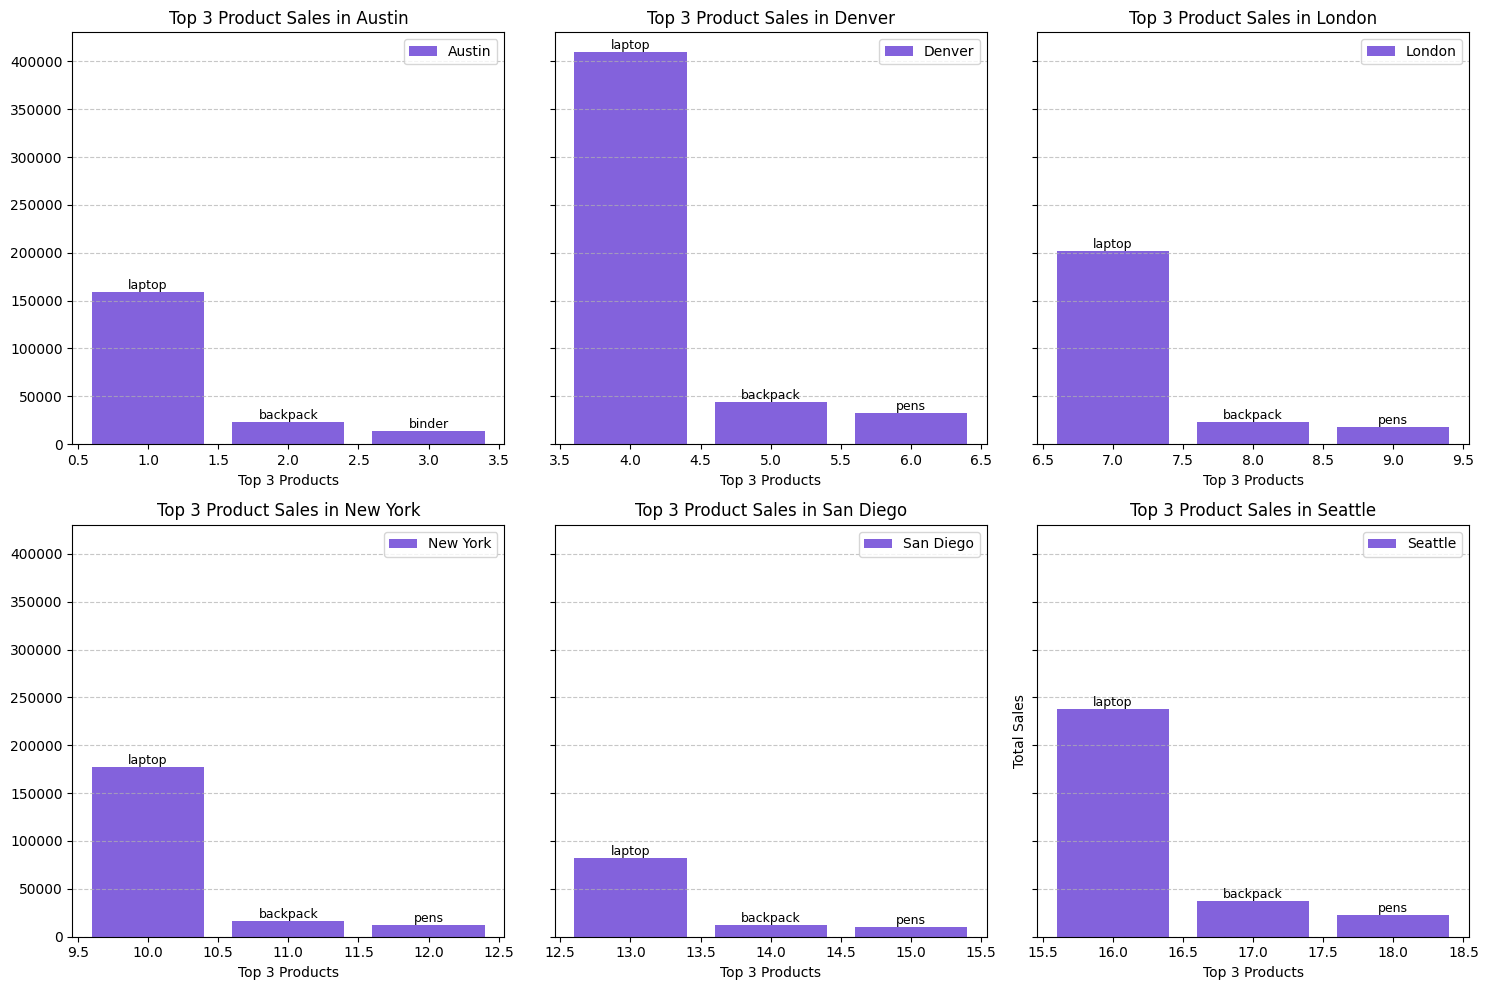

In [36]:
import matplotlib.pyplot as plt

# Separate data for each store
stores = top_3_productsales_by_store['storeLocation'].unique()

# Set up subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

for i, store in enumerate(stores):
    # Calculate the position in the subplot grid
    row = i // 3
    col = i % 3
    
    # Filter data for the current store
    store_data = top_3_productsales_by_store[top_3_productsales_by_store['storeLocation'] == store]
    
    # Plotting the bar chart for the current store
    bars = axes[row, col].bar(store_data['Top3'], store_data['sales'], color='#4e20ce', alpha=0.7, label=store)
    
    # Adding product names as labels on the bars
    for bar, product_name in zip(bars, store_data['name']):
        axes[row, col].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), product_name,
                            ha='center', va='bottom', color='black', fontsize=9)
    
    axes[row, col].set_xlabel('Top 3 Products')
    axes[row, col].set_title(f'Top 3 Product Sales in {store}')
    axes[row, col].grid(axis='y', linestyle='--', alpha=0.7)
    axes[row, col].legend()

# Set common y-axis label
plt.ylabel('Total Sales')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()



#### From the table and graph, laptop has significant sale across all 6 locations than other items, among 6 locations , Denver has the highest sale in laptop
#### all six locations has top 3 products, laptop, backpack and pens in order except in Austin binder is 3rd profitable product instead of pens.
#### Denver has higher sales of all three products than all other location sales

# 3.Show rankings of each store (location)

In [16]:
# Group by store location and calculate total sales
store_rankings = merged_df.groupby('storeLocation')['sales'].sum().reset_index()
# Convert to HTML
html_table = store_rankings.head(3).to_html(classes='customtable', index=False)

# Display the HTML with custom styles for top_3_productsales_by_store
display(HTML(styles + html_table))

storeLocation,sales
Austin,237868.30
Denver,583256.15
London,291162.89


In [37]:
# Sort the values by total sales in descending order
store_rankings = store_rankings.sort_values(by='sales', ascending=False)

# Add a rank column based on total sales
store_rankings['rank'] = range(1, len(store_rankings) + 1)

# Convert to HTML
html_table = store_rankings.to_html(classes='customtable', index=False)

# Add a title to the table
table_title = '<h2>Ranking of Each Store   <--------</h2>'

# Display the HTML with custom styles for top_3_productsales_by_store
display(HTML(styles +table_title+ html_table))

storeLocation,sales,rank
Denver,583256.15,1
Seattle,370600.53,2
London,291162.89,3
Austin,237868.30,4
New York,233406.01,5
San Diego,125525.93,6


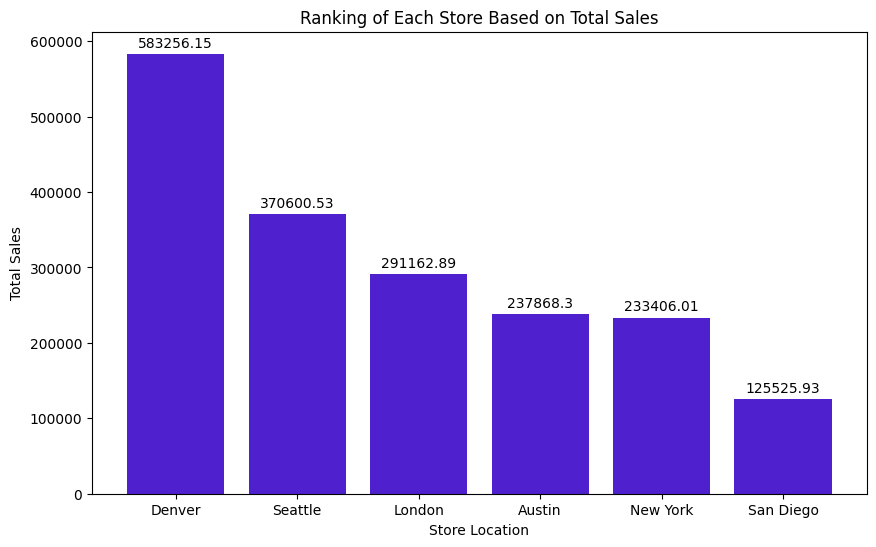

In [21]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the color for the bars to #4e20ce
bar_color = '#4e20ce'

# Plot the bar chart
ax.bar(store_rankings['storeLocation'], store_rankings['sales'], color=bar_color)

# Add labels and title
ax.set_xlabel('Store Location')
ax.set_ylabel('Total Sales')
ax.set_title('Ranking of Each Store Based on Total Sales')

# Add values on top of the bars
for i, v in enumerate(store_rankings['sales']):
    ax.text(i, v + 5000, str(v), ha='center', va='bottom')

# Show the plot
plt.show()



#### As stated in previous observation, Denver is indeed the first rank among other location. From above graphs, Denver has high sales in top 3 products.
#### high sales means customers pay more and they meet their satisfaction and this could link to why Denver is ranked top 1.The same goes for Seattle, which comes in second after Seattle. after dramatic differeces between Denver , Seattle and london, Austin and New York are not such different in their sales. San Diego has the lowest sales thus ranking in 6.

# 4.Show purchased method by gender table 

In [21]:
print(merged_df['purchaseMethod'].unique())

['Online' 'Phone' 'In store']


In [22]:

customer_df = salesdf['customer'].apply(pd.Series)
# Merge the customer information with the items information
merged_customer_df = pd.merge(merged_df, customer_df, left_on='index', right_index=True)
# Convert to HTML
html_table = merged_customer_df.head().to_html(classes='customtable', index=False)

# Display the HTML with custom styles for top_3_productsales_by_store
display(HTML(styles + html_table))

index,name,tags,quantity,price.$numberDecimal,sales,storeLocation,purchaseMethod,saleDate,gender,age,email,satisfaction
0,printer paper,"[office, stationary]",2,40.01,80.02,Denver,Online,{'$date': '2015-03-23T21:06:49.506Z'},M,42,cauho@witwuta.sv,4
1,notepad,"[office, writing, school]",2,35.29,70.58,Seattle,Phone,{'$date': '2015-08-25T10:01:02.918Z'},M,50,keecade@hem.uy,5
2,pens,"[writing, office, school, stationary]",5,56.12,280.60,Denver,In store,{'$date': '2017-06-22T09:54:14.185Z'},M,51,worbiduh@vowbu.cg,5
3,backpack,"[school, travel, kids]",2,77.71,155.42,Seattle,In store,{'$date': '2015-02-23T09:53:59.343Z'},F,45,vatires@ta.pe,3
4,notepad,"[office, writing, school]",2,18.47,36.94,London,In store,{'$date': '2017-12-03T18:39:48.253Z'},M,40,dotzu@ib.sh,4


In [23]:

purchase_by_gender = pd.crosstab(merged_customer_df['gender'], merged_customer_df['purchaseMethod'])

table_title = 'Purchase by Gender <-------'
print(table_title)
print()

# Display the table
print(purchase_by_gender)


Purchase by Gender <-------

purchaseMethod  In store  Online  Phone
gender                                 
F                   1430     813    284
M                   1389     772    312


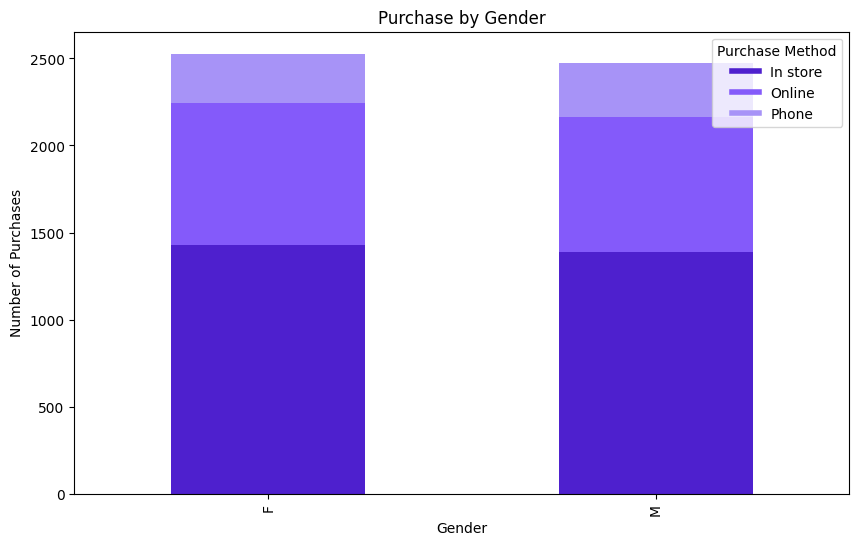

In [33]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each purchase method
colors = {'In store': '#4e20ce', 'Online': '#845afa', 'Phone': '#a793f7'}

# Plot the bar chart with custom colors
purchase_by_gender.plot(kind='bar', stacked=True, ax=ax, color=[colors[method] for method in purchase_by_gender.columns])

# Add labels and title
ax.set_xlabel('Gender')
ax.set_ylabel('Number of Purchases')
ax.set_title('Purchase by Gender')

# Add legend with custom colors
legend_labels = [plt.Line2D([0], [0], color=colors[method], lw=4, label=method) for method in purchase_by_gender.columns]
ax.legend(handles=legend_labels, title='Purchase Method', loc='upper right')

# Show the plot
plt.show()


#### Customers Purchase their proudcts in three ways, in store, online or phone call. Both male and females customers has nearly equal portions of all types of purchase methods according to the graph. Among three of them, they mostly purchase products personally in store, followed by online purchase and phone call the least.

# 5.Show monthly total sales 

In [34]:

merged_customer_df['saleDate'] = merged_customer_df['saleDate'].apply(
    lambda x: x['$date'] if isinstance(x, dict) else x
)

# Convert 'saleDate' to datetime format
merged_customer_df['saleDate'] = pd.to_datetime(
    merged_customer_df['saleDate'], format="%Y-%m-%dT%H:%M:%S.%fZ", errors='coerce'
)

# Drop rows with non-finite (NA or inf) values in 'saleDate'
merged_customer_df = merged_customer_df.dropna(subset=['saleDate'])

# Extracting year and month from 'saleDate'
merged_customer_df['year'] = merged_customer_df['saleDate'].dt.year
merged_customer_df['month'] = merged_customer_df['saleDate'].dt.month

# Convert 'month' and 'year' to integer type
merged_customer_df['month'] = merged_customer_df['month'].astype(int)
merged_customer_df['year'] = merged_customer_df['year'].astype(int)

# Assuming 'sales' is the column representing sales amount
# If it's not present, you may need to check how the sales data is stored in your DataFrame
monthly_total_sales = merged_customer_df.groupby(['year', 'month']).agg({'sales': 'sum'}).reset_index()

# Convert to HTML
html_table = monthly_total_sales.to_html(classes='customtable', index=False)

# Add a title to the table
table_title = '<h2>Monthly Total Sales   <--------</h2>'

# Display the HTML with custom styles for top_3_productsales_by_store
display(HTML(styles + table_title + html_table))



year,month,sales
2013,1,22516.78
2013,2,29306.27
2013,3,19943.84
2013,4,38496.15
2013,5,27018.06
2013,6,33785.74
2013,7,25126.67
2013,8,20167.53
2013,9,27709.83
2013,10,29965.56


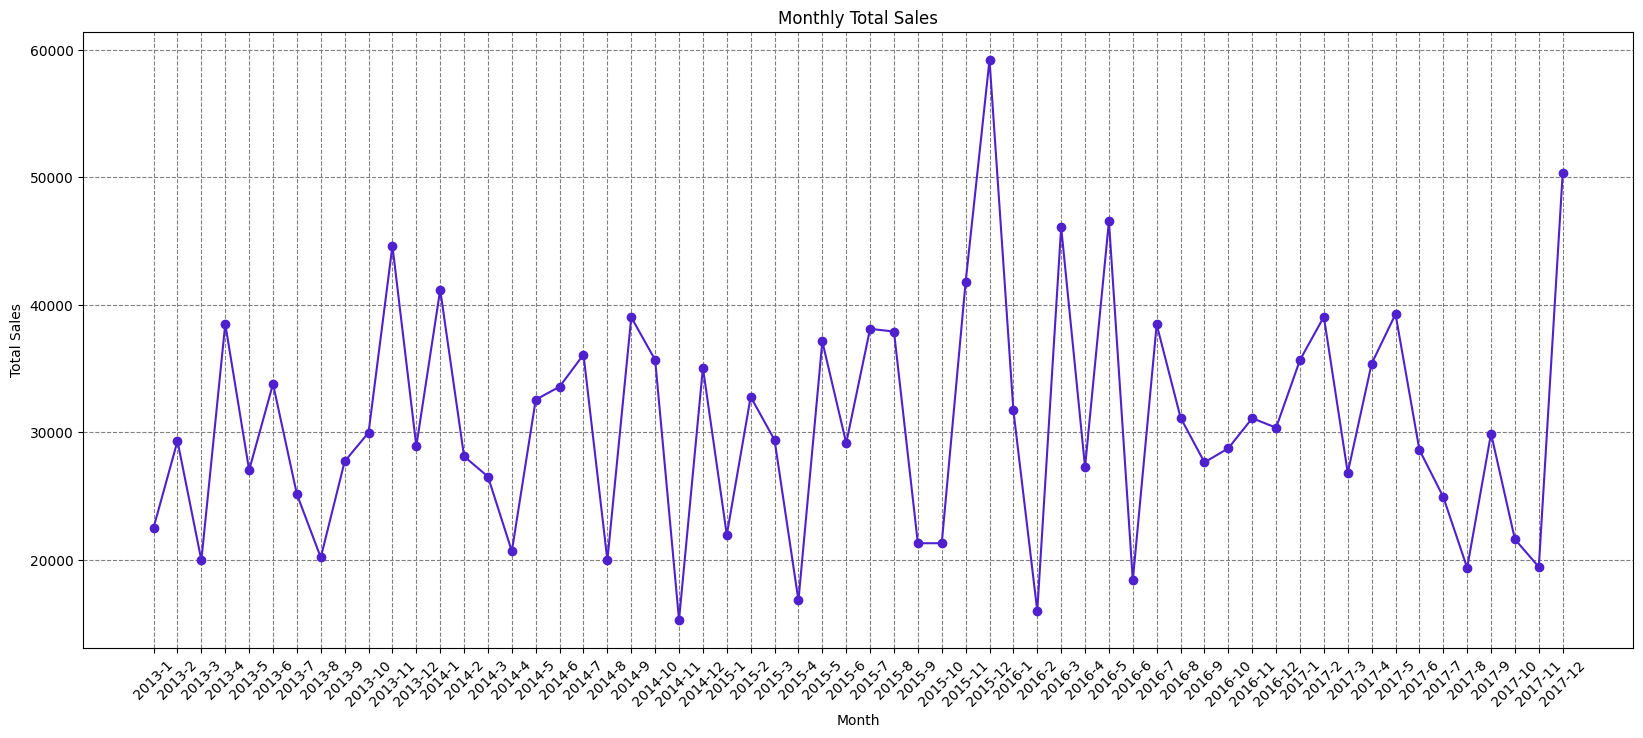

In [43]:
import matplotlib.pyplot as plt

# Set up the figure and axes with a larger figsize
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the line chart with the trendline color set to #4e20ce
ax.plot(monthly_total_sales['year'].astype(str) + '-' + monthly_total_sales['month'].astype(str), 
        monthly_total_sales['sales'], marker='o', color='#4e20ce')

# Add labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Total Sales')
ax.set_title('Monthly Total Sales')

# Change the color of the gridlines to #4e20ce
ax.grid(True, linestyle='--', color='grey')

# Show the plot
plt.xticks(rotation=45)
plt.show()



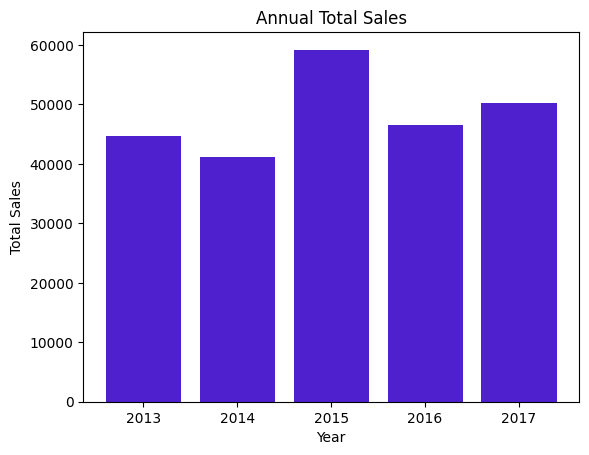

In [44]:
import matplotlib.pyplot as plt

# Assuming 'year' is the column representing the years
# 'total_sales' is the column representing total sales for each year
plt.bar(monthly_total_sales['year'], monthly_total_sales['sales'], color='#4e20ce')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Annual Total Sales')
plt.show()


#### The provided data represents monthly sales figures over a five-year period, spanning from 2013 to 2017. The sales exhibit fluctuations throughout the years, with notable peaks and troughs. Particularly, in November 2013, there is a significant surge in sales, reaching 44,621.42 units. Similarly, December 2015 showcases a substantial spike with sales amounting to 59,211.19 units. These periodic high sales might be attributed to seasonal trends, such as holiday shopping. In contrast, November 2014 records a sharp decline to 15,270.89 units. Over the entire period, 2015 emerges as a year with consistently strong sales, notably due to robust performance in November and December. The data indicates the necessity for businesses to analyze and understand the seasonal patterns influencing their sales, enabling them to optimize inventory, marketing, and other operational strategies accordingly.

# Summary


#### In summary, the dataset reveals key insights into the sales dynamics of seven items across six locations and multiple purchase methods. Notably, laptops stand out as the highest-selling product, emphasizing the prominence of tech products in the market. Denver emerges as the top-performing location, particularly excelling in laptop sales. The top three products, including laptops, backpacks, and pens, consistently dominate sales across most locations, with slight variations in Austin. Seasonal trends, such as the spikes in November 2013 and December 2015, highlight the importance of understanding and adapting to market fluctuations. Overall, Denver and Seattle lead in sales, underscoring the regional variations. Additionally, customers predominantly prefer in-store purchases, followed by online transactions and phone orders. The parity in purchase methods between genders suggests a balanced consumer behavior. As businesses interpret these findings, they gain valuable insights into product performance, regional preferences, and the impact of sales channels, aiding strategic decision-making for future endeavors.